In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

# Предобработка данных

## Загрузка данных

Загрузим данные, в 1 столбце находятся индексы - выделим их.

In [ ]:
filename = 'data.csv'
df = pd.read_csv(filename, sep=',', index_col=0)

Посмотрим на сами данные.

In [ ]:
df.head()

,Id,income,age,experience,married,house_ownership,car_ownership,profession,city,state,current_job_years,current_house_years,risk_flag
0,1,1303835.0,23.0,3.0,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3.0,13.0,0
1,2,7574516.0,40.0,10.0,single,rented,NaN,Software_Developer,Parbhani,Maharashtra,9.0,13.0,0
2,3,3991815.0,66.0,4.0,married,rented,no,Technical_writer,Alappuzha,Kerala,4.0,10.0,0
3,4,6256451.0,41.0,2.0,single,rented,NaN,Software_Developer,NaN,Odisha,2.0,12.0,1
4,5,5768871.0,47.0,NaN,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3.0,NaN,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252000 entries, 0 to 251999
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Id                   252000 non-null  int64  
 1   income               212000 non-null  float64
 2   age                  212000 non-null  float64
 3   experience           212000 non-null  float64
 4   married              212000 non-null  object 
 5   house_ownership      212000 non-null  object 
 6   car_ownership        212000 non-null  object 
 7   profession           212000 non-null  object 
 8   city                 212000 non-null  object 
 9   state                212000 non-null  object 
 10  current_job_years    212000 non-null  float64
 11  current_house_years  212000 non-null  float64
 12  risk_flag            252000 non-null  int64  
dtypes: float64(5), int64(2), object(6)
memory usage: 26.9+ MB


Заметим, что отсутствуют данные типа дата-время (`datetime`).

In [ ]:
df.isna().sum()

Id                         0
income                 40000
age                    40000
experience             40000
married                40000
house_ownership        40000
car_ownership          40000
profession             40000
city                   40000
state                  40000
current_job_years      40000
current_house_years    40000
risk_flag                  0
dtype: int64

Если все пропуски идентичны, тогда после их удаления должно остаться всего `252000-40000=212000` значений. Проверим это, прежде чем заполнять их.

In [ ]:
df.dropna().shape[0]

37844

Получаем, что пропуски имеются, однако не в одинаковых строках, и после удаления останется приблизительно `15%` данных. Такое действие недопустимо, поэтому предобработаем их другими способами.

## Заполнение пропусков, приведение типов

### Общие методы

Напишем метод, ищущий наиболее часто встречающееся значение в колонке. Пропускает все неопределенные (`NaN`) значения. Мы не можем сразу взять все колонки, так как в этом случае пропуск неопределенных значений будет пропускать строки, в которых есть хотя бы одно неопределенное значение.

In [ ]:
def find_mode(df, columns=[], type_vals='string', verbose=False):
    modes = []
    for col in columns:
        uniq, counter = np.unique(df[col].dropna().astype(type_vals), return_counts=True)
        idx = np.argmax(counter)
        modes.append(uniq[idx])
    return modes

In [ ]:
assert find_mode(pd.DataFrame(data=[[1, 4], [4, 4], [2, np.nan], [1, 5]], columns=[0, 1]),
                 columns=[0]) == ['1']
assert find_mode(pd.DataFrame(data=[[1, 4], [4, 4], [2, np.nan], [1, 5]], columns=[0, 1]),
                 columns=[0, 1], type_vals='int64') == [1, 4]

Действительно, данный метод приводит значения к строковым, убирает пропуски и ищет наиболее часто встречаемое значение по колонке.

Напишем метод, ищущий значение по колонке. Значение может быть одним из методов.

In [ ]:
def find_by_col(df, columns=[], type_vals='string', method='mean', verbose=False):
    vals = []
    if verbose:
        print('Find value at columns {} with method {}'.format(columns, method))
    for col in columns:
        if method=='mean':
            if type_vals not in ['float64', 'int64']:
                type_vals = 'float64'
            find = np.mean(df[col].dropna().astype(type_vals))
            if type_vals == 'int64':
                find = int(find)
            vals.append(find)
    return vals

In [ ]:
assert find_by_col(pd.DataFrame(data=[[1, 4], [4, 4], [2, np.nan], [1, 5]], columns=[0, 1]),
                 columns=[0], type_vals='int64') == [int((1+4+2+1)/4.)]

Напишем метод, заполняющий значения по переданному правилу `method`, иначе - модой.

In [ ]:
def fill_na(df, columns=[], method=None, type_vals='string', verbose=False):
    if verbose:
        print('Fill values:')
    if method is None:
        method = find_mode
    fill_vals = method(df, columns=columns, type_vals=type_vals, verbose=verbose)
    for i, col in enumerate(columns):
        if verbose:
            print('fill col {} with value {}'.format(col, fill_vals[i]))
        df[col] = df[col].fillna(fill_vals[i]).astype(type_vals)
    print()
    return df

In [ ]:
assert fill_na(pd.DataFrame(data=[[1, 4], [4, 4], [2, np.nan], [1, 5]], columns=[0, 1]),
                 columns=[1]).loc[2, 1] == '4.0'

Посмотрим на значения типа `object` - предполагаем, что они строковые.

In [ ]:
str_cols=['married', 'house_ownership', 'car_ownership', 'profession', 'city', 'state']

In [ ]:
df[str_cols].head()

,married,house_ownership,car_ownership,profession,city,state
0,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh
1,single,rented,NaN,Software_Developer,Parbhani,Maharashtra
2,married,rented,no,Technical_writer,Alappuzha,Kerala
3,single,rented,NaN,Software_Developer,NaN,Odisha
4,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu


Посмотрим число уникальных элементов по каждой колонке. Если значений меньше 10, напечатаем их.

In [ ]:
def print_uniq_vals(df, columns=[], max_print=10, verbose=True):
    if verbose:
        print('Find unique values in columns')
    for col in columns:
        uniq = np.unique(df[col].dropna().astype('string'))
        if verbose:
            print('Column {} have {} unique values.'.format(col, len(uniq)))
        if len(uniq) <= max_print:
            print(uniq)
    print()

In [ ]:
print_uniq_vals(df, columns=str_cols, verbose=True)

Find unique values in columns
Column married have 2 unique values.
['married' 'single']
Column house_ownership have 3 unique values.
['norent_noown' 'owned' 'rented']
Column car_ownership have 2 unique values.
['no' 'yes']
Column profession have 51 unique values.
Column city have 317 unique values.
Column state have 29 unique values.



Видим, что колонки `married` и `car_ownership` являются бинарными.

### Обработка даты-время

Отсутствуют колонки типа дата-время в датасете.

### Обработка числовых значений

Обработка числовых значений по умолчанию является одной из самых простых задач. Однако все может быть не так просто, как кажется на первый взгляд. Посмотрим на распределение числовых значений в датасете.

In [ ]:
df.describe()

,Id,income,age,experience,current_job_years,current_house_years,risk_flag
count,252000.000000,2.120000e+05,212000.000000,212000.000000,212000.000000,212000.000000,252000.000000
mean,126000.500000,5.001149e+06,49.944627,10.100670,6.332241,11.997156,0.123000
std,72746.278255,2.879121e+06,17.059594,6.003362,3.644469,1.398789,0.328438
min,1.000000,1.031000e+04,21.000000,0.000000,0.000000,10.000000,0.000000
25%,63000.750000,2.504720e+06,35.000000,5.000000,3.000000,11.000000,0.000000
50%,126000.500000,5.008596e+06,50.000000,10.000000,6.000000,12.000000,0.000000
75%,189000.250000,7.479878e+06,65.000000,15.000000,9.000000,13.000000,0.000000
max,252000.000000,9.999938e+06,79.000000,20.000000,14.000000,14.000000,1.000000


Видим, что колонка `Id` неинформативна - в ней содержатся id клиентов. Избавимся от нее.

In [ ]:
df = df.drop(['Id'], axis=1)

In [ ]:
num_cols = ['income', 'age', 'experience', 'current_job_years','current_house_years', 'risk_flag']

Посмотрим на распределение колонки `age` - возможно, имеет смысл привести ее к целочисленному типу

In [ ]:
print_uniq_vals(df, columns=num_cols, max_print=59, verbose=True)

Find unique values in columns
Column income have 36145 unique values.
Column age have 59 unique values.
['21.0' '22.0' '23.0' '24.0' '25.0' '26.0' '27.0' '28.0' '29.0' '30.0'
 '31.0' '32.0' '33.0' '34.0' '35.0' '36.0' '37.0' '38.0' '39.0' '40.0'
 '41.0' '42.0' '43.0' '44.0' '45.0' '46.0' '47.0' '48.0' '49.0' '50.0'
 '51.0' '52.0' '53.0' '54.0' '55.0' '56.0' '57.0' '58.0' '59.0' '60.0'
 '61.0' '62.0' '63.0' '64.0' '65.0' '66.0' '67.0' '68.0' '69.0' '70.0'
 '71.0' '72.0' '73.0' '74.0' '75.0' '76.0' '77.0' '78.0' '79.0']
Column experience have 21 unique values.
['0.0' '1.0' '10.0' '11.0' '12.0' '13.0' '14.0' '15.0' '16.0' '17.0'
 '18.0' '19.0' '2.0' '20.0' '3.0' '4.0' '5.0' '6.0' '7.0' '8.0' '9.0']
Column current_job_years have 15 unique values.
['0.0' '1.0' '10.0' '11.0' '12.0' '13.0' '14.0' '2.0' '3.0' '4.0' '5.0'
 '6.0' '7.0' '8.0' '9.0']
Column current_house_years have 5 unique values.
['10.0' '11.0' '12.0' '13.0' '14.0']
Column risk_flag have 2 unique values.
['0' '1']



Видим, что колонка `age` действительно заполнена всего 59 значениями от 21 до 79. Заполним ее целочисленными значениями. Также заполним целочисленными значениями колонки `experience`, `current_job_years`, `current_house_years`.

Колонка `risk_flag ` имеет всего 2 различных значения - она бинарная

Колонка `income` имеет большое стандартное отклонение и имеет смысл заполнить значения средним по колонке

In [ ]:
float_cols = ['income']
df = fill_na(df, columns=float_cols, method=find_by_col, type_vals='float64', verbose=True)

Fill values:
Find value at columns ['income'] with method mean
fill col income with value 5001148.634896226



Также заполним колонки `age`, `experience`, `current_job_years` средними, но уже типа `int32`

In [ ]:
int_cols=['age', 'experience', 'current_job_years', 'current_house_years']
df = fill_na(df, columns=int_cols, method=find_by_col, type_vals='int64', verbose=True)

Fill values:
Find value at columns ['age', 'experience', 'current_job_years', 'current_house_years'] with method mean
fill col age with value 49
fill col experience with value 10
fill col current_job_years with value 6
fill col current_house_years with value 11



Посмотрим на корелляцию числовых признаков между собой после заполнения

In [ ]:
df[num_cols].corr()

,income,age,experience,current_job_years,current_house_years,risk_flag
income,1.000000,-0.001968,0.003519,0.006259,0.000009,-0.002937
age,-0.001968,1.000000,-0.002021,0.001337,-0.016107,-0.020922
experience,0.003519,-0.002021,1.000000,0.542194,0.013883,-0.032749
current_job_years,0.006259,0.001337,0.542194,1.000000,0.004155,-0.015364
current_house_years,0.000009,-0.016107,0.013883,0.004155,1.000000,-0.002834
risk_flag,-0.002937,-0.020922,-0.032749,-0.015364,-0.002834,1.000000


<AxesSubplot:>

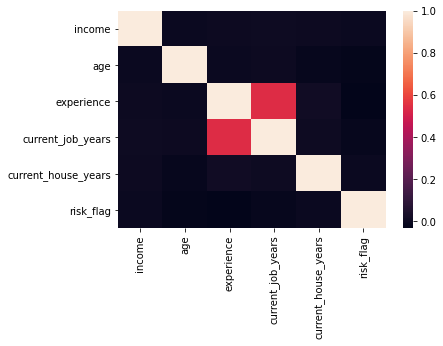

In [ ]:
sns.heatmap(df[num_cols].corr())

Видим, что признаки слабо кореллируют между собой (кроме `experience` и `current_job_years`) - дополнительных действий не требуется. Замечаем, что пары колонок
- `income`, `experience`;
- `income`, `current_job_years`;
- `income`, `current_house_years`;
- `income`, `risk_flag`;
- `age`, `experience`;
- `age`, `current_job_years`;
- `current_job_years`, `current_house_years`,
слабо кореллируют между собой. Возможно, придется избавиться от одной или нескольких из данных колонок впоследствии.

### Обработка бинарных значений

Напишем функцию, обрабатывающую бинарные значения

In [ ]:
bin_cols = ['married', 'car_ownership', 'risk_flag']

Данная функция будет заполнять пропуски наиболее часто встречающимся значением и приводить в бинарный вид (0, 1)

In [ ]:
def prepare_bin_cols(df, columns=[], type_vals='string', type_vals_end='int64', verbose=False):
    if verbose:
        print('Prepare binary columns: {}'.format(columns))
    df = fill_na(df, columns=columns, verbose=verbose)
    for col in columns:
        uniq = np.unique(df[col].dropna().astype(type_vals))
        mapping = {val:str(i) for i, val in enumerate(uniq)}
        if verbose:
            print('Change values to binary at column {} with values {}'.format(col, mapping))
        df[col] = df[col].map(mapping).astype(type_vals_end)
    if verbose:
        print()
    return df

In [ ]:
df = prepare_bin_cols(df, columns=bin_cols, verbose=True)

Prepare binary columns: ['married', 'car_ownership', 'risk_flag']
Fill values:
fill col married with value single
fill col car_ownership with value no
fill col risk_flag with value 0

Change values to binary at column married with values {'married': '0', 'single': '1'}
Change values to binary at column car_ownership with values {'no': '0', 'yes': '1'}
Change values to binary at column risk_flag with values {'0': '0', '1': '1'}



### Обработка конкатенирующих значений

Конкатенирующих значений не выделено - однако в столбцах `city` встречается числовый постфикс вида $[X], X \in \mathbb {N}$. Уберем данный постфикс, заполним недостающие значения модой

Функция `remove_num` убирает числовое значение после города

In [ ]:
def remove_num(value):
    idx = value.find('[')
    if idx != -1:
        value = value[:idx]
    return value

In [ ]:
assert remove_num('abc') == 'abc'
assert remove_num('abc[132]') == 'abc'

In [ ]:
def iter_row(column):
    res = []
    for i, val in enumerate(column):
        res.append(remove_num(val))
    return res

def iter_col(columns):
    columns.apply(iter_row)
    return columns

def remove_postfix(df, columns=[], type_vals='string', verbose=False):
    if verbose:
        print('Remove numeric postfix values at column {}'.format(columns))
    df = fill_na(df, columns=columns, verbose=verbose)
    df[columns] = df[columns].apply(iter_row)
    return df

In [ ]:
df = remove_postfix(df, columns=['city', 'state'], verbose=True)

Remove numeric postfix values at column ['city', 'state']
Fill values:
fill col city with value Vijayanagaram
fill col state with value Uttar_Pradesh



### Обработка строковых (категориальных) значений

In [ ]:
cat_cols = list(set(df.columns) - set(int_cols + float_cols + bin_cols))
cat_cols

['state', 'house_ownership', 'profession', 'city']

In [ ]:
df[cat_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252000 entries, 0 to 251999
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   state            252000 non-null  object
 1   house_ownership  212000 non-null  object
 2   profession       212000 non-null  object
 3   city             252000 non-null  object
dtypes: object(4)
memory usage: 9.6+ MB


Как мы помним, среди текущих столбцов отсутствуют бинарные значения. Посмотрим на сами данные и на уникальные значения по столбцам

In [ ]:
df[cat_cols].head()

,state,house_ownership,profession,city
0,Madhya_Pradesh,rented,Mechanical_engineer,Rewa
1,Maharashtra,rented,Software_Developer,Parbhani
2,Kerala,rented,Technical_writer,Alappuzha
3,Odisha,rented,Software_Developer,Vijayanagaram
4,Tamil_Nadu,rented,Civil_servant,Tiruchirappalli


In [ ]:
print_uniq_vals(df, columns=cat_cols, max_print=10, verbose=True)

Find unique values in columns
Column state have 28 unique values.
Column house_ownership have 3 unique values.
['norent_noown' 'owned' 'rented']
Column profession have 51 unique values.
Column city have 316 unique values.



Число городов достаточно велико, однако в среднем на 1 город приходится `252000/317=8200` людей. Поэтому можно для всех колонок применить `one-hot` кодирование, предварительно заполнив значениями `Undefined`

In [ ]:
def find_undefined(df, columns=[], type_vals='string', verbose=False):
    if verbose:
        print('Find Undefined for columns: {}'.format(columns))
    return ['Undefined'] * len(columns)

In [ ]:
assert find_undefined([], columns=[]) == []
assert find_undefined([], columns=[1, 'a']) == ['Undefined', 'Undefined']

In [ ]:
def prepare_cat_cols(df, columns=[], type_vals='string', verbose=False):
    shape_before = df.shape
    if verbose:
        print('Prepare categorical columns: {}'.format(columns))
    df = fill_na(df, columns=columns, verbose=verbose, method=find_undefined)
    df = pd.get_dummies(df, columns=columns)
    if verbose:
        shape_after = df.shape
        print('One-hot coding: shape before: {}, shape after {}'.format(shape_before, shape_after), end='\n\n')
    return df

In [ ]:
df = prepare_cat_cols(df, columns=cat_cols, verbose=True)

Prepare categorical columns: ['state', 'house_ownership', 'profession', 'city']
Fill values:
Find Undefined for columns: ['state', 'house_ownership', 'profession', 'city']
fill col state with value Undefined
fill col house_ownership with value Undefined
fill col profession with value Undefined
fill col city with value Undefined

One-hot coding: shape before: (252000, 12), shape after (252000, 408)



## Полная предобработка

Напишем метод, загружающий и полностью предобрабатывающий датасет по правилам выше.

In [ ]:
def full_prep(filename='data.csv', index_col=0, useless_cols=['Id'], datetime_cols=[],
              int_cols=['age', 'experience', 'current_job_years', 'current_house_years'],
              float_cols=['income'], bin_cols = ['married', 'car_ownership', 'risk_flag'],
             concat_cols=['city', 'state']):
    # Get dataset
    print('Get dataset by path: {}'.format(filename))
    df = pd.read_csv(filename, sep=',', index_col=index_col)
    # Remove useless columns
    print('Drop columns: {}'.format(useless_cols))
    df = df.drop(useless_cols, axis=1)
    # PREPARATION COLUMNS
    # datetime columns are missed at dataset
    print('No datetime columns')
    # float columms
    df = fill_na(df, columns=float_cols, method=find_by_col, type_vals='float64', verbose=True)
    # int columns
    df = fill_na(df, columns=int_cols, method=find_by_col, type_vals='int64', verbose=True)
    # binary columns
    df = prepare_bin_cols(df, columns=bin_cols, verbose=True)
    # concatenate columns are missed at dataset
    df = remove_postfix(df, columns=concat_cols, verbose=True)
    # Find categorical values
    cat_cols = list(set(df.columns) - set(int_cols + float_cols + bin_cols))
    # Categorical cols
    df = prepare_cat_cols(df, columns=cat_cols, verbose=True)
    return df

In [ ]:
df_new = full_prep()

Get dataset by path: data.csv
Drop columns: ['Id']
No datetime columns
Fill values:
Find value at columns ['income'] with method mean
fill col income with value 5001148.634896226

Fill values:
Find value at columns ['age', 'experience', 'current_job_years', 'current_house_years'] with method mean
fill col age with value 49
fill col experience with value 10
fill col current_job_years with value 6
fill col current_house_years with value 11

Prepare binary columns: ['married', 'car_ownership', 'risk_flag']
Fill values:
fill col married with value single
fill col car_ownership with value no
fill col risk_flag with value 0

Change values to binary at column married with values {'married': '0', 'single': '1'}
Change values to binary at column car_ownership with values {'no': '0', 'yes': '1'}
Change values to binary at column risk_flag with values {'0': '0', '1': '1'}

Remove numeric postfix values at column ['city', 'state']
Fill values:
fill col city with value Vijayanagaram
fill col state 

Проверяем, что не осталось неопределенных значений.

In [ ]:
df_new.isna().sum().sum()

0

Данная функция добавляет постфикс к слову.

In [ ]:
def add_postfix(filename='', postfix='_prepared', sep='.'):
    names = filename.split(sep)
    names[0] += postfix
    new_filename = sep.join(names)
    return new_filename

Сохраним датасет c префиксом `prepared`.

In [ ]:
new_filename = add_postfix(filename=filename)
df_new.to_csv(new_filename, index=False)

In [ ]:
df_new = pd.read_csv(new_filename)
df_new.head()

,income,age,experience,married,car_ownership,current_job_years,current_house_years,risk_flag,state_Andhra_Pradesh,state_Assam,...,city_Unnao,city_Vadodara,city_Varanasi,city_Vasai-Virar,city_Vellore,city_Vijayanagaram,city_Vijayawada,city_Visakhapatnam,city_Warangal,city_Yamunanagar
0,1303835.0,23,3,1,0,3,13,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7574516.0,40,10,1,0,9,13,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3991815.0,66,4,0,0,4,10,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6256451.0,41,2,1,0,2,12,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5768871.0,47,10,1,0,3,11,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Создадим функцию, объединяющую создание, предобработку и сохранение предобработанного датасета.

In [ ]:
def prepare_and_save(filename='data.csv', index_col=0, useless_cols=['Id'],
              int_cols=['age', 'experience', 'current_job_years', 'current_house_years'],
              float_cols=['income'], bin_cols = ['married', 'car_ownership', 'risk_flag'],
             concat_cols=['city', 'state'], postfix='prepared', index=False):
    df = full_prep(filename=filename, index_col=index_col, useless_cols=useless_cols,
              int_cols=int_cols, float_cols=float_cols, bin_cols=bin_cols, concat_cols=concat_cols)
    new_filename = add_postfix(filename=filename)
    print('Save prepared dataset as {}'.format(new_filename))
    df.to_csv(new_filename, index=False)
    return df

Выполняем предобработку датасета и сохраняем его.

In [ ]:
df_new = prepare_and_save()

Get dataset by path: data.csv
Drop columns: ['Id']
No datetime columns
Fill values:
Find value at columns ['income'] with method mean
fill col income with value 5001148.634896226

Fill values:
Find value at columns ['age', 'experience', 'current_job_years', 'current_house_years'] with method mean
fill col age with value 49
fill col experience with value 10
fill col current_job_years with value 6
fill col current_house_years with value 11

Prepare binary columns: ['married', 'car_ownership', 'risk_flag']
Fill values:
fill col married with value single
fill col car_ownership with value no
fill col risk_flag with value 0

Change values to binary at column married with values {'married': '0', 'single': '1'}
Change values to binary at column car_ownership with values {'no': '0', 'yes': '1'}
Change values to binary at column risk_flag with values {'0': '0', '1': '1'}

Remove numeric postfix values at column ['city', 'state']
Fill values:
fill col city with value Vijayanagaram
fill col state 

Проверяем, что не осталось неопределенных значений.

In [ ]:
df_new.isna().sum().sum()

0

In [ ]:
df_new.head()

,income,age,experience,married,car_ownership,current_job_years,current_house_years,risk_flag,state_Andhra_Pradesh,state_Assam,...,city_Unnao,city_Vadodara,city_Varanasi,city_Vasai-Virar,city_Vellore,city_Vijayanagaram,city_Vijayawada,city_Visakhapatnam,city_Warangal,city_Yamunanagar
0,1303835.0,23,3,1,0,3,13,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7574516.0,40,10,1,0,9,13,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3991815.0,66,4,0,0,4,10,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6256451.0,41,2,1,0,2,12,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5768871.0,47,10,1,0,3,11,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Предобработка данных завершена.